In [2]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [3]:
from importlib import reload
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import torch
import torch.nn as nn
import k3d
import skimage.morphology as morp

import general.nn.viz.canva as cva
import general.nn.viz.element as viz_element
import general.nn.viz.plot_symbols as ps
import general.nn.viz.plot_letters as plet
import general.nn.viz.element_symbols as es
import general.nn.viz.element_image as ei
import general.nn.viz.element_arrow as ea
import general.nn.viz.element_circle as ec
import general.nn.viz.element_letters as el
import general.nn.viz.plot_histogram as ph
import general.nn.viz as all_viz
import general.array_morphology as arm
import deep_morpho.viz.element_arrow_no as eltarno
import deep_morpho.morp_operations as mo
import deep_morpho.viz.morp_operations_viz as mov
import deep_morpho.viz.elt_generator_morpop as elgenmo


# import deep_morpho.viz.morp_operations_viz2 as mov2

import deep_morpho.threshold_fn as tfn
import deep_morpho.models.weights_layer as wl
import deep_morpho.models.bimonn as bimonn
import deep_morpho.viz.element_lui as elui
# import deep_morpho.viz.element_lui2 as elui2
import deep_morpho.viz.element_bise as ebise
import deep_morpho.viz.element_generator as egen
import deep_morpho.viz.skeleton_morp_viz as skmov
import deep_morpho.viz.elt_generator_init as egen_init
import deep_morpho.viz.elt_generator_bimonn as egen_bimonn
import deep_morpho.viz.bimonn_viz as bviz
# import deep_morpho.viz.bimonn_viz2 as bviz2

import deep_morpho.datasets.generate_forms3 as gf3

def reload_modules():
    for modl in [
        cva, viz_element, ps, plet, es, ei, ea, ec, el, ph, all_viz, arm, eltarno, mo, mov, elgenmo,
        tfn, wl, bimonn, elui, ebise, bviz, egen, skmov, egen_init, egen_bimonn, gf3
    ]:
        reload(modl)

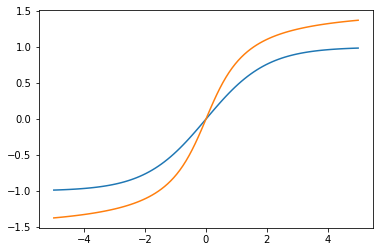

In [3]:
reload_modules()
x = torch.tensor(np.linspace(-5, 5, 100))
y = tfn.sigmoid_threshold_symetric(x)
y2 = torch.arctan(x)

plt.plot(x, y)
plt.plot(x, y2)


# Ellipse Weights

In [207]:
reload_modules()
N = 11
a = 1
std = np.sqrt(1/(0.001 * 30))
A = torch.tensor([
    [1/std**2, 0.00],
    [0.00, 1/std**2]
]).float()
mu = torch.tensor([N // 2, N // 2]).float()
# mu = torch.tensor([N // 2, N // 2])[..., None].float()

W = wl.WeightsEllipse.ellipse_matrix((N, N), mu=mu, sigma_inv=A, a_=a, )

In [208]:
def mean_theory2(n_samples, n):
    xs = np.linspace(0, n, n_samples)
    return np.exp(-(xs - n/2)**2 / (std ** 2)).mean()

def cdf_not_norm(x, std):
    return np.sqrt(np.pi) * std * torch.erf(torch.tensor([x / std]))

def mean_theory(std, n):
    n = n - 1
    return 1 / n**2 * std ** 2 * np.pi * torch.erf(torch.tensor(n) / (2 * std)) ** 2

def var_theory(std, n):
    n = n - 1
    return 1 / n**2 * std ** 2 / 2 * np.pi * torch.erf(n / torch.sqrt(2) * 1 / std) ** 2 - mean_theory(std, n) ** 2

print()
print("Mean exp", mean_theory2(n_samples=100000, n=N-1) ** 2)
print("With erf", (cdf_not_norm(N//2, std=std) /(N-1) ) ** 2)

print()
print('Mean theory', mean_theory(std=std, n=N))
print('Mean discrete', W.mean())

print()
print("Var theory", var_theory(std=std, n=N))
print("Var discrete", W.var())


Mean exp 0.6360135203159573
With erf tensor([0.6360], dtype=torch.float64)



TypeError: sqrt(): argument 'input' (position 1) must be Tensor, not int

In [142]:
n = 6*6
torch.erf(torch.tensor([n / std]))

tensor([1.], dtype=torch.float64)

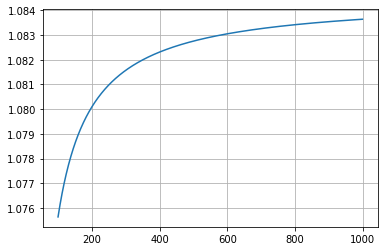

In [123]:



    
xs = np.arange(11)
mean_discrete = np.exp(-(xs - N//2)**2 / (std ** 2)).mean() ** 2

all_samples = np.arange(100, 1000)
res = []
res2 = []
for n_sample in all_samples:
    res.append(mean_theory2(n_sample) / mean_discrete)
    res2.append(mean_theory2(n_sample) / mean_theory(std=std, n=N*M))
plt.plot(all_samples, res, label='discrete')
# plt.plot(all_samples, res2, label='theory')
plt.grid()

tensor(0.5864) tensor(0.2060)
tensor([0.0005])


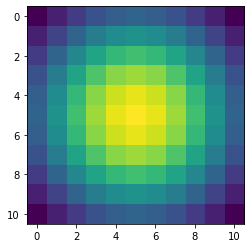

In [121]:
print(W.mean(), W.std())
print(mean_theory(std, N * M))
plt.imshow(W)

In [56]:
def var_w(n, sigma):
    return (
        4 / (n**2) * np.exp(- 2 * np.arange(n // 2) / sigma).sum()** 2 -
        (16 / n ** 4) * np.exp(- np.arange(n // 2) / sigma).sum()** 4
    )

100

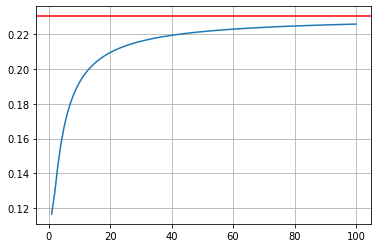

In [91]:
xs = np.linspace(1, 100, 100)
ys = []

n = 5

for x in xs:
    ys.append(var_w(n=n, sigma=x))


plt.axhline(4/(n**2) * (n // 2)**2 - (16 / (n**4)) * (n // 2)**4, c='r')
plt.plot(xs, ys)

plt.grid('on')

0.19491878384006656

In [5]:
torch.ones((3, 4, 5)).transpose(2, 1).shape

torch.Size([3, 5, 4])

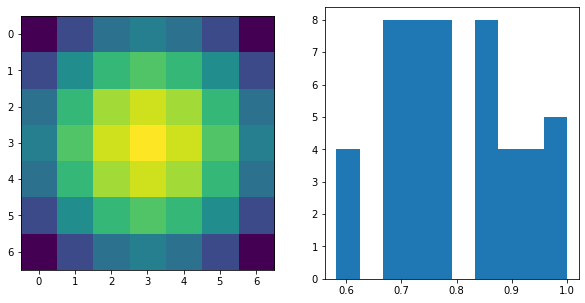

In [55]:
def ellipse_level_torch(x: torch.Tensor, mu: torch.Tensor, sigma_inv: torch.Tensor, a):
    A1 = (x - mu).T @ sigma_inv
    A2 = (x - mu).T
    res = torch.bmm(A1[:, None, :], A2[..., None])
    return torch.exp(-res ** a)

N, M = 7, 7
a = 1
A = torch.tensor([
    [0.001, 0.00],
    [0.00, 0.001]
]).float() * 30
mu = torch.tensor([N // 2, M // 2])[..., None].float()

el1 = partial(ellipse_level_torch, mu=mu, sigma_inv=A, a=a)

# XX, YY = torch.tensor(np.meshgrid(np.arange(N), np.arange(N)))
# coords = torch.tensor(np.vstack([XX.flatten(), YY.flatten()]))

XX, YY = torch.meshgrid(torch.arange(N), torch.arange(M))
coords = torch.vstack([XX.flatten(), YY.flatten()])


W = el1(coords).reshape(N, M)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(W);
plt.subplot(122)
plt.hist(W.flatten().numpy());

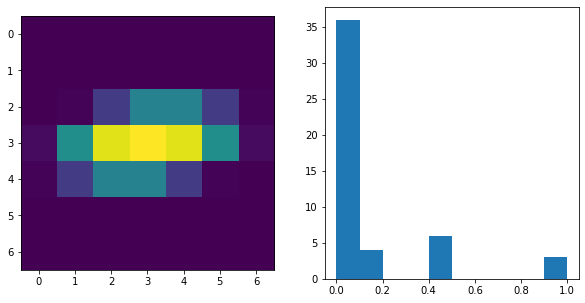

In [30]:
def ellipse_level(x: np.ndarray, mu: np.ndarray, sigma_inv: np.ndarray, a):
    return np.diag(np.exp(-((x - mu).T @ sigma_inv @ (x - mu)) ** a))

N = 7
a = 2
A = np.array([
    [0.007, 0.003],
    [0.004, 0.03]
]) * 30
mu = np.array([N // 2, N // 2])[..., None]

el1 = partial(ellipse_level, mu=mu, sigma_inv=A, a=a)

XX, YY = np.meshgrid(np.arange(N), np.arange(N))
coords = np.vstack([XX.flatten(), YY.flatten()])

W = el1(coords).reshape(N, N)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(W);
plt.subplot(122)
plt.hist(W.flatten());

In [19]:
W.shape

(2500,)

In [15]:
(coords - mu).T.shape

(2, 2500)

# Array Morphology

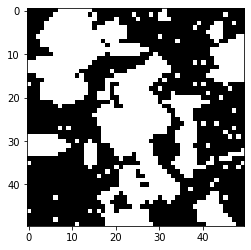

In [7]:
img = gf3.get_random_rotated_diskorect(size=(50, 50), border=(0, 0))
plt.imshow(img, cmap='gray')

Erosion


Text(0.5, 1.0, 'Difference')

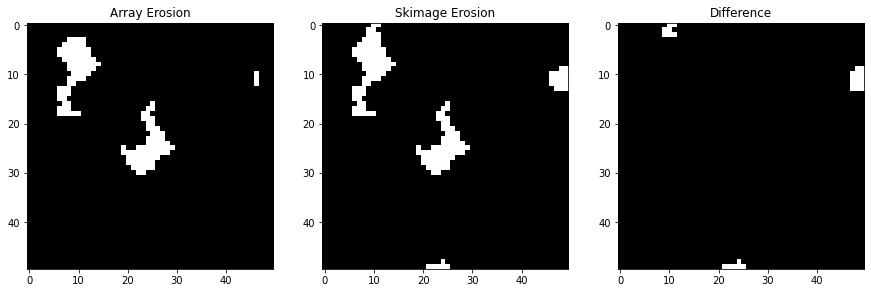

In [18]:
selem = morp.disk(3)
ero1 = arm.array_erosion(img, selem)
ero2 = morp.erosion(img, selem)

print('Erosion')

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(ero1, cmap='gray', interpolation="nearest")
plt.title('Array Erosion')

plt.subplot(132)
plt.imshow(ero2, cmap='gray', interpolation="nearest")
plt.title('Skimage Erosion')

plt.subplot(133)
plt.imshow(np.abs(ero2 - ero1), cmap='gray', interpolation="nearest")
plt.title('Difference')

Dilation


Text(0.5, 1.0, 'Difference')

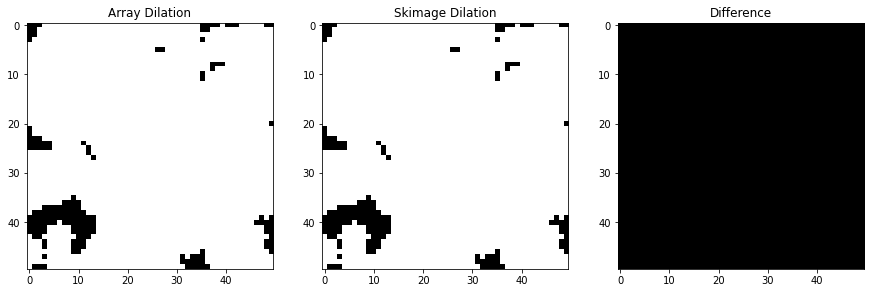

In [19]:
selem = morp.disk(3)
ero1 = arm.array_dilation(img, selem)
ero2 = morp.dilation(img, selem)

print('Dilation')

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(ero1, cmap='gray', interpolation="nearest")
plt.title('Array Dilation')

plt.subplot(132)
plt.imshow(ero2, cmap='gray', interpolation="nearest")
plt.title('Skimage Dilation')

plt.subplot(133)
plt.imshow(np.abs(ero2 - ero1), cmap='gray', interpolation="nearest")
plt.title('Difference')

Text(0.5, 1.0, 'Difference')

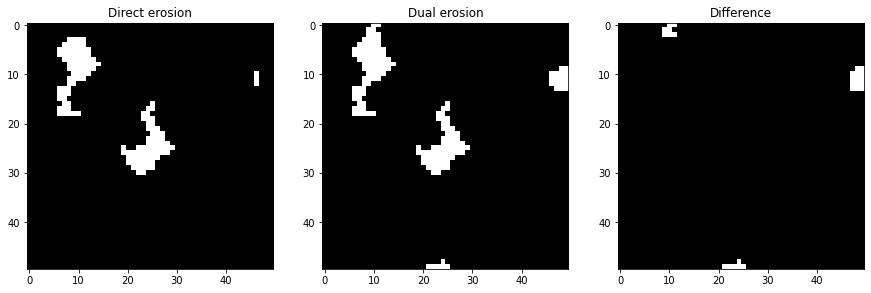

In [20]:
ero1 = arm.array_erosion(img, selem)
ero2 = 1 - arm.array_dilation(1 - img, selem)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(ero1, cmap='gray', interpolation="nearest")
plt.title('Direct erosion')

plt.subplot(132)
plt.imshow(ero2, cmap='gray', interpolation="nearest")
plt.title('Dual erosion')

plt.subplot(133)
plt.imshow(np.abs(ero2 - ero1), cmap='gray', interpolation="nearest")
plt.title('Difference')

# Some level sets

In [2]:
N = 200

XX, YY = np.meshgrid(np.arange(N), np.arange(N))

In [3]:
def plot_lvset_ax(ax, im, eps=2e-3):
    mask = np.zeros_like(im)
    im_norm = im / im.max()
    mask[(-eps < im_norm) & (im_norm < eps)] = 1
    mask = np.ma.masked_where(mask == 0, mask)
    ax.imshow(im, cmap='gray')
    ax.imshow(mask, cmap='jet')

In [4]:
def get_circle_fn(center, radius):
    def fn(*x):
        return np.sqrt((x[0] - center[0])**2 + (x[1] - center[1])**2) - radius
    return fn

def Rtheta(theta):
    return np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])

def get_square_fn(center, radius, angle):
    def fn(*x):
        W, L = x[0].shape
        Xs = x[0].reshape(W*L)
        Ys = x[1].reshape(W*L)
        coords = np.vstack((Xs, Ys))
        return (
            np.abs(Rtheta(theta) @ (coords - center[..., np.newaxis])).sum(0) - radius
        ).reshape(W, L)
    return fn


In [71]:
def get_ellipse_fn(center, matrix, radius):
    def fn(*x):
        W, L = x[0].shape
        Z = np.zeros_like(x[0])
        for i in range(W):
            for j in range(L):
                coord = np.array([x[0][i, j], x[1][i, j]]) - center
                coord = coord[:, np.newaxis]
                Z[i, j] = np.sqrt( coord.T @ matrix @ coord) - radius
        return Z
    return fn

In [119]:
A = np.array([
    [4, 2],
    [2, 2]
]) * 5
center = np.array([75, 60])
radius = 100

fn_ellipse = get_ellipse_fn(center, A, radius)
lvset = fn_ellipse(XX, YY)

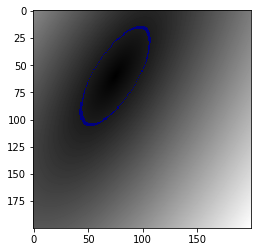

In [120]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 5e-3)

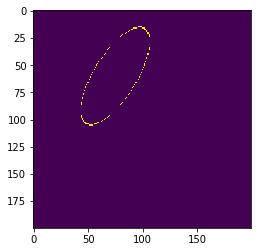

In [123]:
eps = 1e-1
mask = np.zeros_like(lvset)
mask[(-eps < lvset) & (lvset < eps)] = 1
plt.imshow(mask, interpolation='nearest')

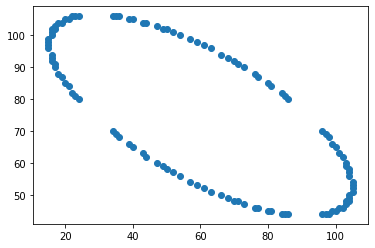

In [124]:
Xs, Ys = np.where(mask)
plt.scatter(Xs, Ys)

In [115]:
c = np.array([100, 100])
r = 50
theta = np.pi / 3

sq_fn = get_square_fn(c, r, theta)

lvset = sq_fn(XX, YY)

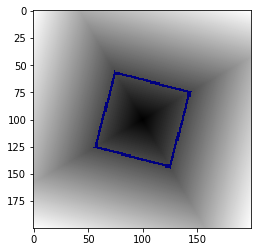

In [6]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 2e-2)

In [180]:
c = np.array([150, 100])
r = 20

cir_fn = get_circle_fn(c, r)

lvset = cir_fn(XX, YY)

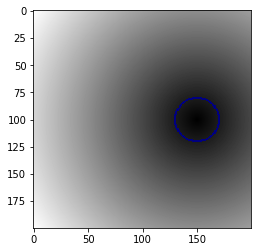

In [182]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 1e-2)

# Plot Symbols

<AxesSubplot:>

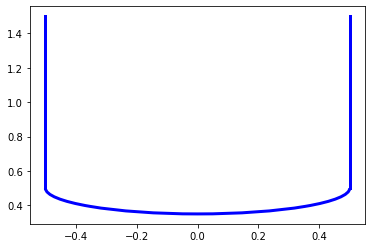

In [8]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_union_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

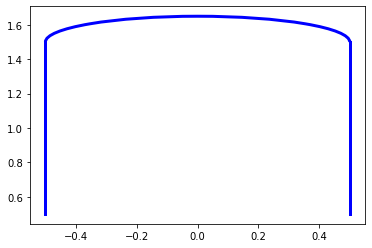

In [42]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_intersection_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

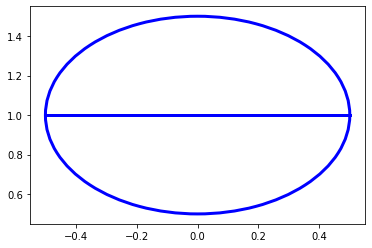

In [9]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_erosion_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

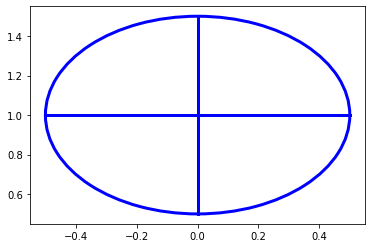

In [47]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_dilation_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

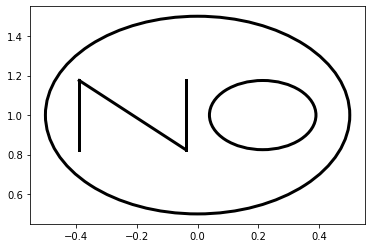

In [33]:
reload_modules()

fig, ax = plt.subplots(1,1)

plet.plot_NO_on_ax(ax, width=1, center=[0, 1], linewidth=3)

<AxesSubplot:>

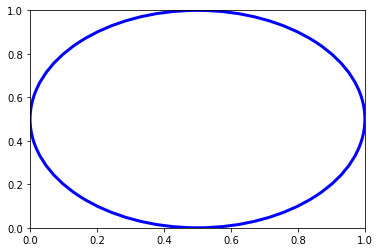

In [23]:
reload_modules()

fig, ax = plt.subplots(1,1)

plet.plot_O_on_ax(ax, height=1, center=[0.5, .5], color='blue', linewidth=3)

# Plot Histogram

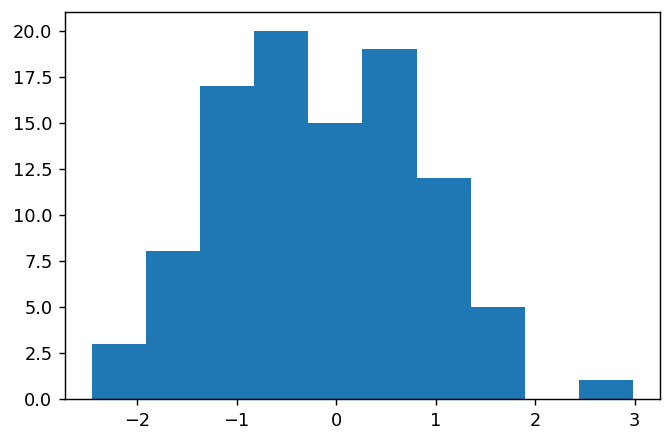

In [24]:
x = np.random.randn(100)

fig, ax = plt.subplots(dpi=128)
ax.hist(x);

In [22]:
x = 2 * (torch.rand((32, 1, 50, 50)).view(-1).numpy() + 20)
ar = ph.get_hist_as_array(x, dpi=50, density=True)
print(ar.shape)
# plt.imshow(ar)



(200, 300, 4)


# Plot Parallel Morp Ops

In [3]:
# morp_operation = mo.ParallelMorpOperations(
#     operations=[
#         [
#             [("erosion", ("vstick", 7), False), "intersection"],
#             [("dilation", ("dcross", 7), False), "union"]
#         ],
#         [
#             [("dilation", ("scross", 7), False), ("erosion", ("square", 7), False), ("intersection", [0])],
#             [("dilation", ("scross", 7), False), ("erosion", ("square", 7), False), "intersection"],
#         ],
#     ]
# )
# morp_operation = mo.ParallelMorpOperations.opening(("disk", 3))
morp_operation = mo.ParallelMorpOperations.black_tophat(('disk', 3))

Viz 1


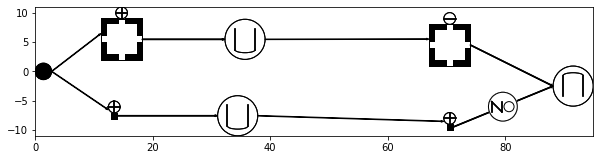

In [38]:
reload_modules()
visu = mov.MorpOperationsVizualiser(morp_operation);
# layer_group = visu.get_layer_group(0)
visu.draw(figsize=(10, 10), axis="on")
print("Viz 1")


Viz 2


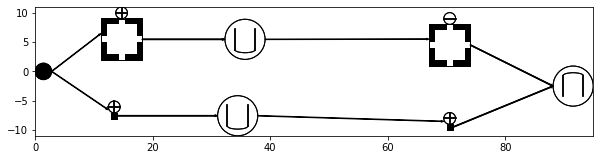

In [23]:
reload_modules()
visu = mov2.MorpOperationsVizualiser(morp_operation);
# layer_group = visu.get_layer_group(0)
visu.draw(figsize=(10, 10), axis="on")
print("Viz 2")


# Plot SMorph

In [10]:
import deep_morpho.biblio_comparison.models as bmod
import deep_morpho.biblio_comparison.vizualiser as bviz

def reload_biblio():
    for modl in [bmod, bviz]:
        reload(modl)

In [32]:
reload_biblio()
model = bmod.NetAdaptativeMorphologicalLayer(
    kernel_size=[(7, 7), (7, 7)],
)

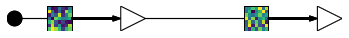

In [33]:
reload_biblio()
bviz.SequentialWeightVizualiser(model).draw()

# Plot BiMoNN

In [3]:
reload_modules()
# net = bimonn.BiMoNN(
#     kernel_size=[5, 5, 5, 5],
#     channels=[1, 2, 3, 2, 1],
#     atomic_element="bisel",
#     threshold_mode="tanh",
#     constant_activation_P=False,
#     constant_weight_P=True,
#     init_weight_mode="conv",
# )
net = bimonn.BiMoNNClassifier(
    kernel_size=[5, 5],
    input_size=(28, 28),
    n_classes=10,
    channels=[1, 2, 1],
    atomic_element="bisel",
    threshold_mode="tanh",
    constant_activation_P=False,
    constant_weight_P=True,
    init_weight_mode="conv",
)
net.layers[1].bise_0.activation_threshold_layer.P_.requires_grad= False
net.layers[1].bise_0.activation_threshold_layer.P_.data = torch.tensor([-10])

/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bise.py:135: UserWarning: init weight mode conv not recognized. Classical conv init used.
  warnings.warn(f"init weight mode {self.init_weight_mode} not recognized. Classical conv init used.")


In [5]:
net.cuda()

BiMoNNClassifier(
  (layer1): BiSEL(
    (bise_0): BiSE(
      (conv): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
      (softplus_layer): Softplus(beta=1, threshold=20)
      (weight_threshold_layer): TanhLayer()
      (activation_threshold_layer): TanhLayer()
    )
    (lui_0): LUI(
      (threshold_layer): TanhLayer()
      (linear): Linear(in_features=1, out_features=1, bias=True)
      (softplus_layer): Softplus(beta=1, threshold=20)
    )
    (lui_1): LUI(
      (threshold_layer): TanhLayer()
      (linear): Linear(in_features=1, out_features=1, bias=True)
      (softplus_layer): Softplus(beta=1, threshold=20)
    )
  )
  (layer2): BiSEL(
    (bise_0): BiSE(
      (conv): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
      (softplus_layer): Softplus(beta=1, threshold=20)
      (weight_threshold_layer): TanhLayer()
      (activation_threshold_layer): TanhLayer()
    )
    (bise_1): BiSE(
      (c

Viz 1


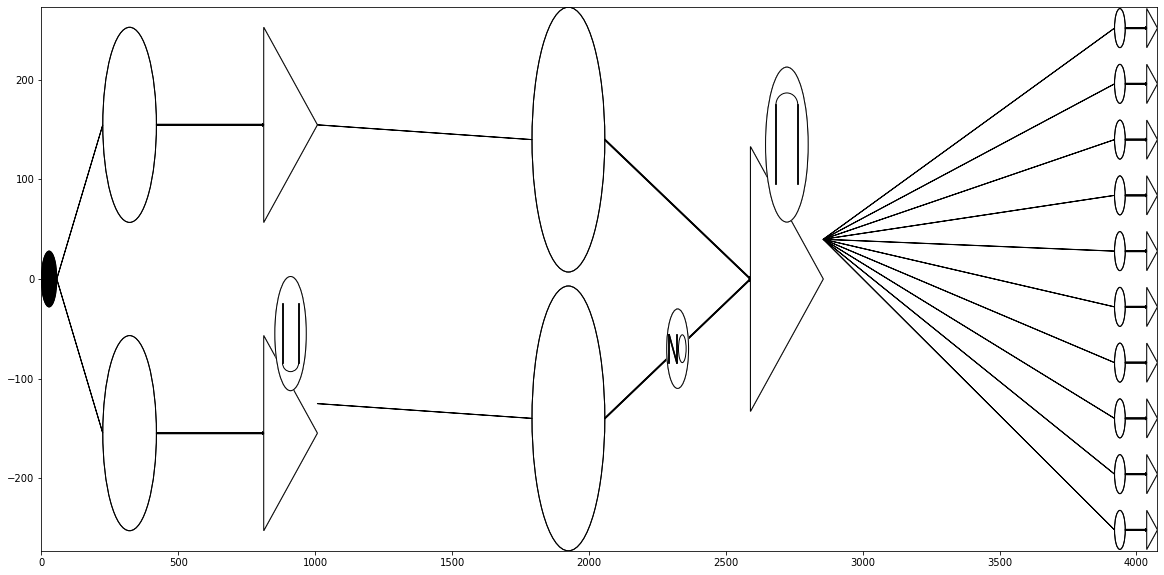

In [4]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode='learned')
viz.draw(axis="on", figsize=(20, 10))
print('Viz 1')

Viz 2


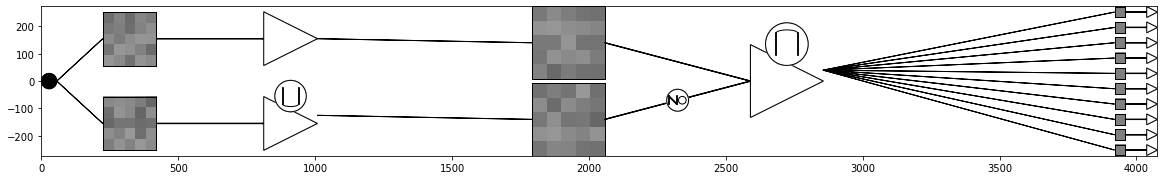

In [5]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode="weights")
viz.draw(axis="on", figsize=(20, 10))
print("Viz 2")

Viz 2


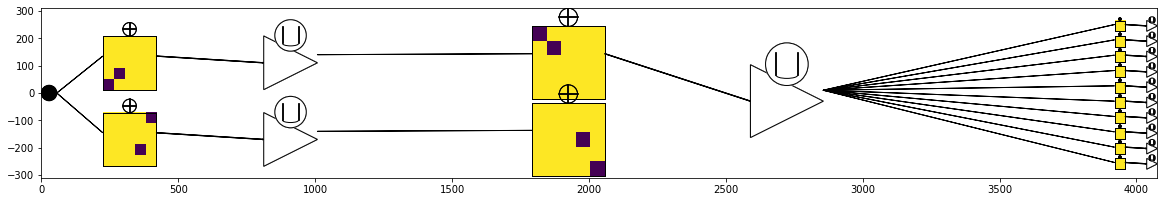

In [6]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode="closest")
viz.draw(axis="on", figsize=(20, 10))
print("Viz 2")

[6. 3.]
[56.       19.115625]
[96. 26.]
[136.   24.5]
[176.   17.5]


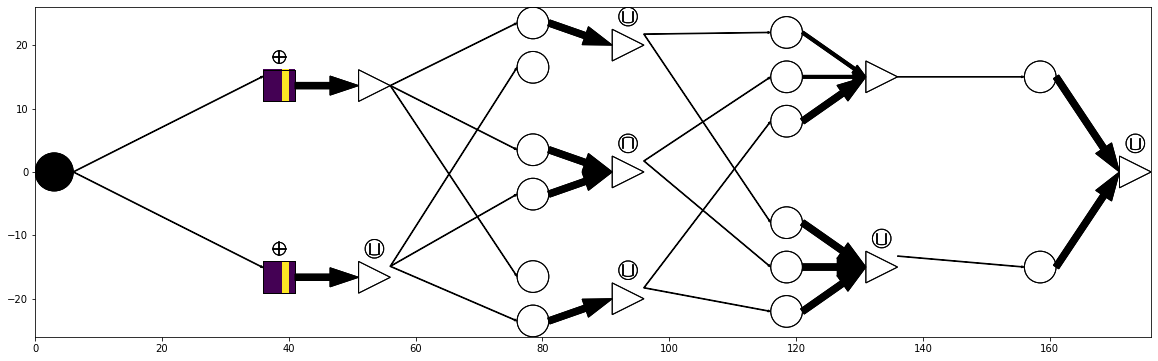

In [44]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode='selem')
viz.draw(axis="on", figsize=(20, 10))

In [81]:
viz.box_height

42

In [45]:
viz.box_height

60

# Faisable binary sets

In [49]:
# S1 = (1, 0)
xs = np.arange(20)
ys = np.arange(20)
zs = np.arange(20)

S1 = []
for x in xs:
    for y in range(x + 1, 20):
        for z in range(x, y):
            S1.append(np.array([x, y, z]) / 20)
S1 = np.array(S1)

S2 = []
for y in xs:
    for x in range(y + 1, 20):
        for z in range(y, x):
            S2.append(np.array([x, y, z]) / 20)
S2 = np.array(S2)

S3 = []
for x in xs:
    for y in ys:
        for z in range(0, min(x, y)):
            S3.append(np.array([x, y, z]) / 20)
S3 = np.array(S3)

In [53]:
plot_S1 = k3d.points(positions=S1[::10], point_size=0.01, color=0xff0000)
plot_S2 = k3d.points(positions=S2[::10], point_size=0.01, color=0x4dff00)
plot_S3 = k3d.points(positions=S3[::10], point_size=0.01,)

plot = k3d.plot()
plot += plot_S1 + plot_S2 + plot_S3
plot

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera_animation=[], camer…

In [58]:
plot_S1 = k3d.points(positions=S1[::10], point_size=0.01, color=0xff0000)
plot_S2 = k3d.points(positions=S2[::10], point_size=0.01, color=0x4dff00)
plot_S3 = k3d.points(positions=S3[::10], point_size=0.01,)


plot = k3d.plot()
vertices_w2 = [[0, 0, 0], [0, 1, 1], [1, 0, 0], [1, 1, 1]]
indices_w2 = [[0, 1, 2], [1, 2, 3]]
mesh_w2 = k3d.mesh(vertices_w2, indices_w2, opacity=.9, color=0xff0000)

vertices_w1 = [[0, 0, 0], [1, 0, 1], [0, 1, 0], [1, 1, 1]]
indices_w1 = [[0, 1, 2], [1, 2, 3]]
mesh_w1 = k3d.mesh(vertices_w1, indices_w1, opacity=.9, color=0x4dff00)


plot += plot_S1 + plot_S2 + plot_S3
plot += mesh_w2
plot += mesh_w1
plot

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera_animation=[], camer…

Text(0, 0, '01-01-2022')

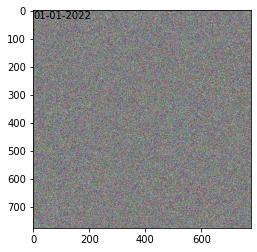

In [17]:

W = np.random.randint(300, 800)
img = np.random.rand(W, W, 3)

def plot_string_on_img(img, text, savepath):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img)
    ax.text(0, 0, text, ha="left", va="top")
    fig.savefig(savepath)


In [3]:
help()

2